# Phase 2: Feature Engineering - Contextual & Linguistic Enrichment
The objetive of this phase is to improve the baseline by incorporating conversational context (Q+A), expanding semantic reach (N-grams), and utilizing domain-specific news embeddings.

## Imports & Data Loading

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

from src.preprocessing import get_preprocessed_data
from src.evaluate import run_full_evaluation
SEED = 42

train_df, val_df, test_df, id2label, label2id = get_preprocessed_data()

y_train_clarity = train_df['clarity_label']
y_val_clarity = val_df['clarity_label']

y_train_evasion = train_df['evasion_label']
y_val_evasion = val_df['evasion_label']

## Experiment 1: Contextual Input (Question + Answer)
In this experiment, we test the hypothesis that the relationship between the question and the answer is more informative than the answer alone. 

We use the `combined_text` column created in our preprocessing script: `[Question] [SEP] [Answer]`.

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Confusion matrices saved to: figures/confusion_matrices_Phase_2_-_Contextual_Sub-Q.png


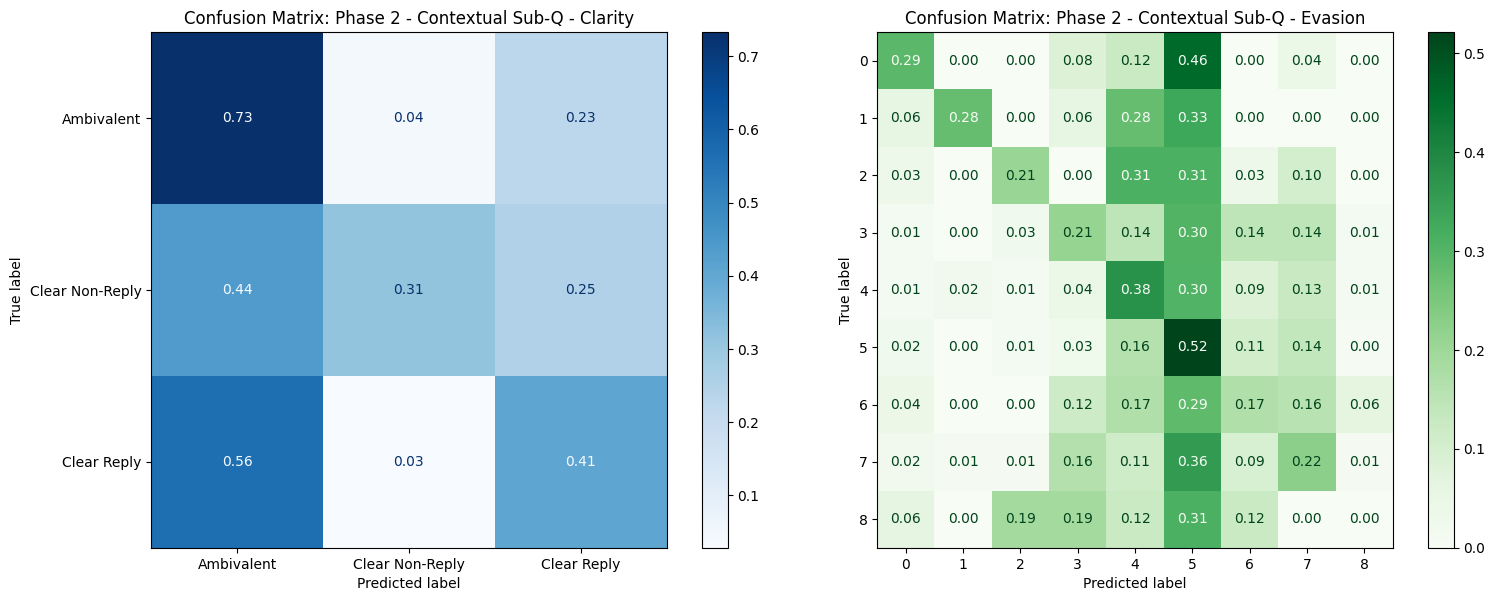

In [9]:
X_train_ctx = train_df['interview_question'].fillna('') + " [SEP] " + train_df['interview_answer'].fillna('')
X_val_ctx = val_df['interview_question'].fillna('') + " [SEP] " + val_df['interview_answer'].fillna('')

countvect = CountVectorizer(stop_words= 'english', ngram_range=(1, 2), max_features=None)
X_train_countvect = countvect.fit_transform(X_train_ctx)
X_val_countvect = countvect.transform(X_val_ctx)

clf_clarity = LogisticRegression(max_iter=1000, multi_class="multinomial", random_state=SEED)
clf_clarity.fit(X_train_countvect, y_train_clarity)

clf_evasion = LogisticRegression(max_iter=1000, multi_class="multinomial", random_state=SEED)
clf_evasion.fit(X_train_countvect, y_train_evasion)

results = run_full_evaluation(
    clf_clarity=clf_clarity,
    clf_evasion=clf_evasion,
    X=X_val_countvect,
    y_clarity=y_val_clarity,
    y_evasion=y_val_evasion,
    title="Phase 2 - Contextual Sub-Q"
)

### Experiment 1.1: Sub-Question vs. Full Interview Question
The `clarity_label` is specifically mapped to the `question` (the isolated sub-question). 
Hypothesis: The model will perform better if we focus on the specific sub-question rather than the full (and often noisy) original interview text.

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Confusion matrices saved to: figures/confusion_matrices_Exp_1.1_-_Sub-Question_Context.png


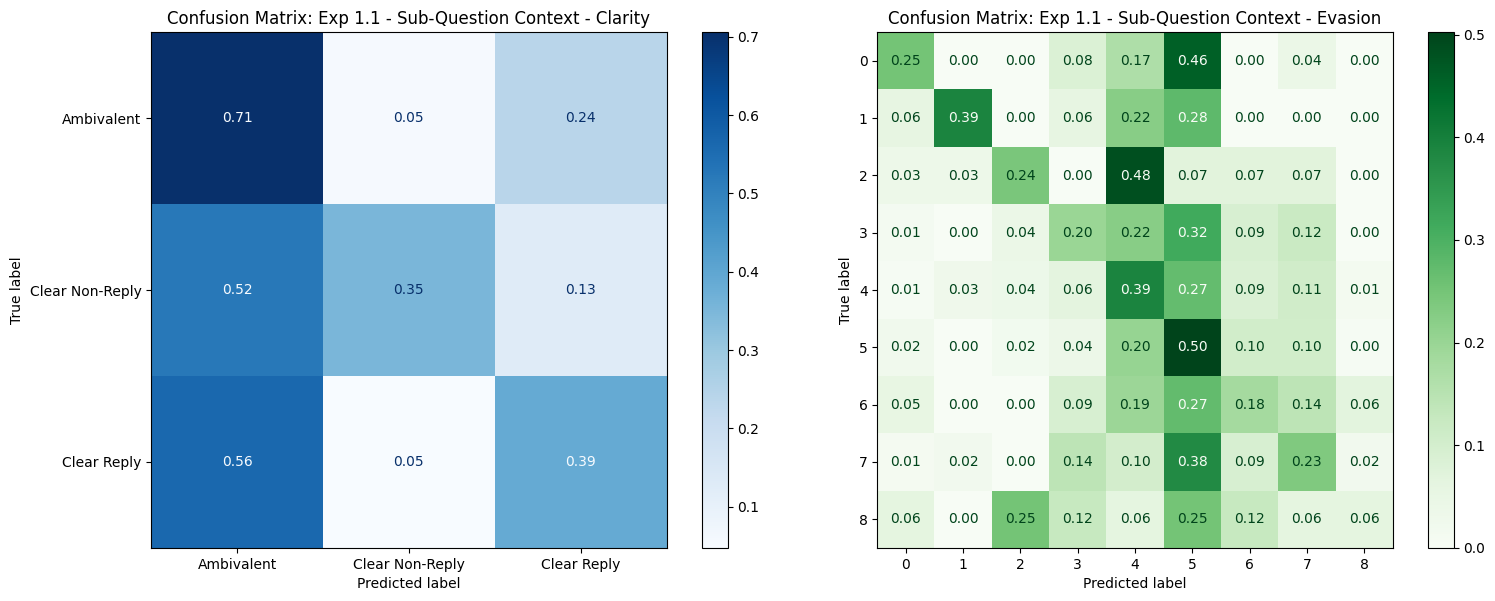

In [10]:
for df in [train_df, val_df, test_df]:
    df['sub_q_context'] = df['question'].fillna('') + " [SEP] " + df['interview_answer'].fillna('')

X_train_sub = train_df['sub_q_context']
X_val_sub = val_df['sub_q_context']

countvect_sub = CountVectorizer(stop_words='english', ngram_range=(1, 2), max_features=None)
X_train_countvect_sub = countvect_sub.fit_transform(X_train_sub)
X_val_countvect_sub = countvect_sub.transform(X_val_sub)

clf_clarity_sub = LogisticRegression(max_iter=1000, multi_class="multinomial", random_state=SEED)
clf_clarity_sub.fit(X_train_countvect_sub, y_train_clarity)

clf_evasion_sub = LogisticRegression(max_iter=1000, multi_class="multinomial", random_state=SEED)
clf_evasion_sub.fit(X_train_countvect_sub, y_train_evasion)

results_ex1_1 = run_full_evaluation(
    clf_clarity=clf_clarity_sub,
    clf_evasion=clf_evasion_sub,
    X=X_val_countvect_sub,
    y_clarity=y_val_clarity,
    y_evasion=y_val_evasion,
    title="Exp 1.1 - Sub-Question Context"
)

### Experiment 1.2: Adding Rhetorical Meta-features
Some evasion is structural. If a question is "affirmative" (leading) or if there were "multiple questions," the probability of a "Non-Reply" or "Ambivalent" label increases. 

We will use a `ColumnTransformer` to combine text (TF-IDF) with numerical features.

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Confusion matrices saved to: figures/confusion_matrices_Exp_1.2_-_Context_+_Meta-features.png


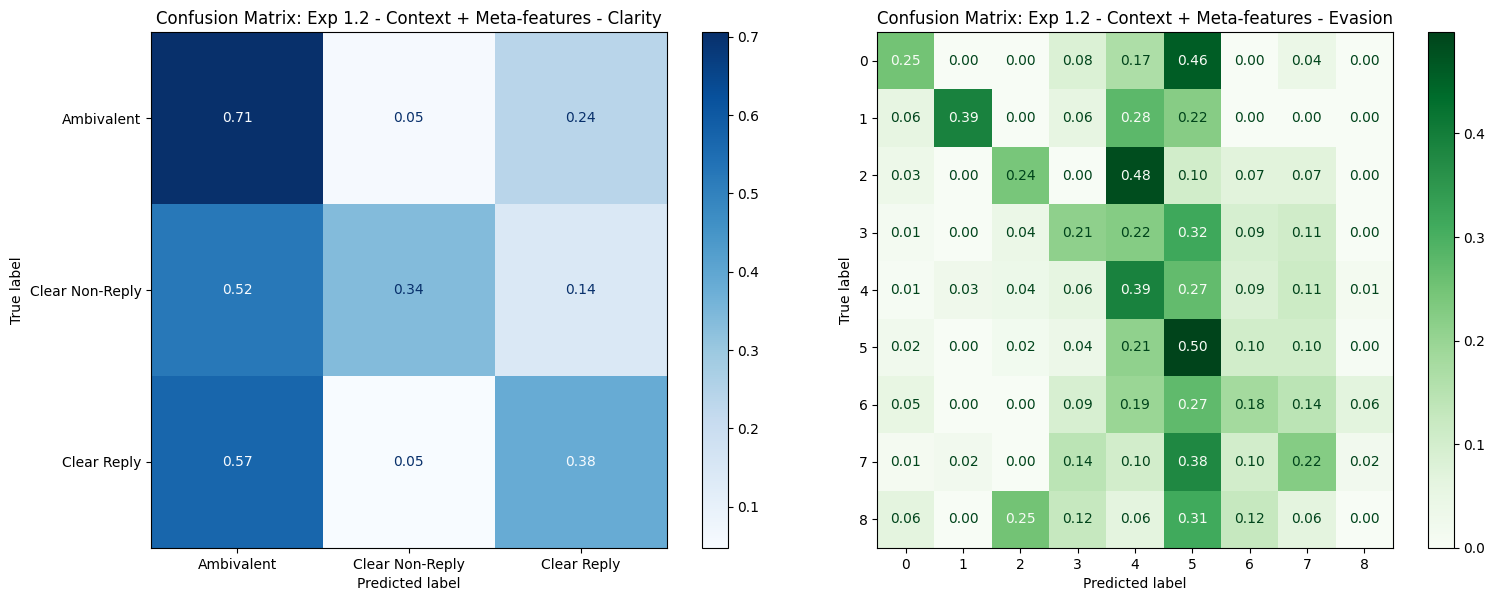

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

meta_cols = ['multiple_questions', 'affirmative_questions', 'inaudible']

for df in [train_df, val_df, test_df]:
    for col in meta_cols:
        df[col] = df[col].astype(int)

preprocessor = ColumnTransformer(
    transformers=[
        ('text', CountVectorizer(stop_words='english', ngram_range=(1, 2), max_features=None), 'sub_q_context'),
        ('meta', 'passthrough', meta_cols)
    ]
)

pipe_clarity = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, multi_class="multinomial", random_state=SEED))
])

pipe_evasion = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, multi_class="multinomial", random_state=SEED))
])

pipe_clarity.fit(train_df, y_train_clarity)
pipe_evasion.fit(train_df, y_train_evasion)

results_ex1_2 = run_full_evaluation(
    clf_clarity=pipe_clarity,
    clf_evasion=pipe_evasion,
    X=val_df,
    y_clarity=y_val_clarity,
    y_evasion=y_val_evasion,
    title="Exp 1.2 - Context + Meta-features"
)

### Results comparison


EXPERIMENT 1 SUMMARY: Comparing All Sub-Experiments

📊 RESULTS COMPARISON:
              Experiment  F1 Macro (Clarity)  Accuracy (Clarity)  F1 Macro (Evasion)  Accuracy (Evasion)
Exp 1: Question + Answer            0.499899            0.589855            0.267519            0.336232
 Exp 1.1: Sub-Q + Answer            0.492227            0.572464            0.282324            0.339130
   Exp 1.2: Sub-Q + Meta            0.486072            0.569565            0.275354            0.336232

🏆 BEST PERFORMERS:
Best for Clarity:  Exp 1: Question + Answer
  F1 Macro: 0.4999
  Accuracy: 0.5899

Best for Evasion:  Exp 1.1: Sub-Q + Answer
  F1 Macro: 0.2823
  Accuracy: 0.3391


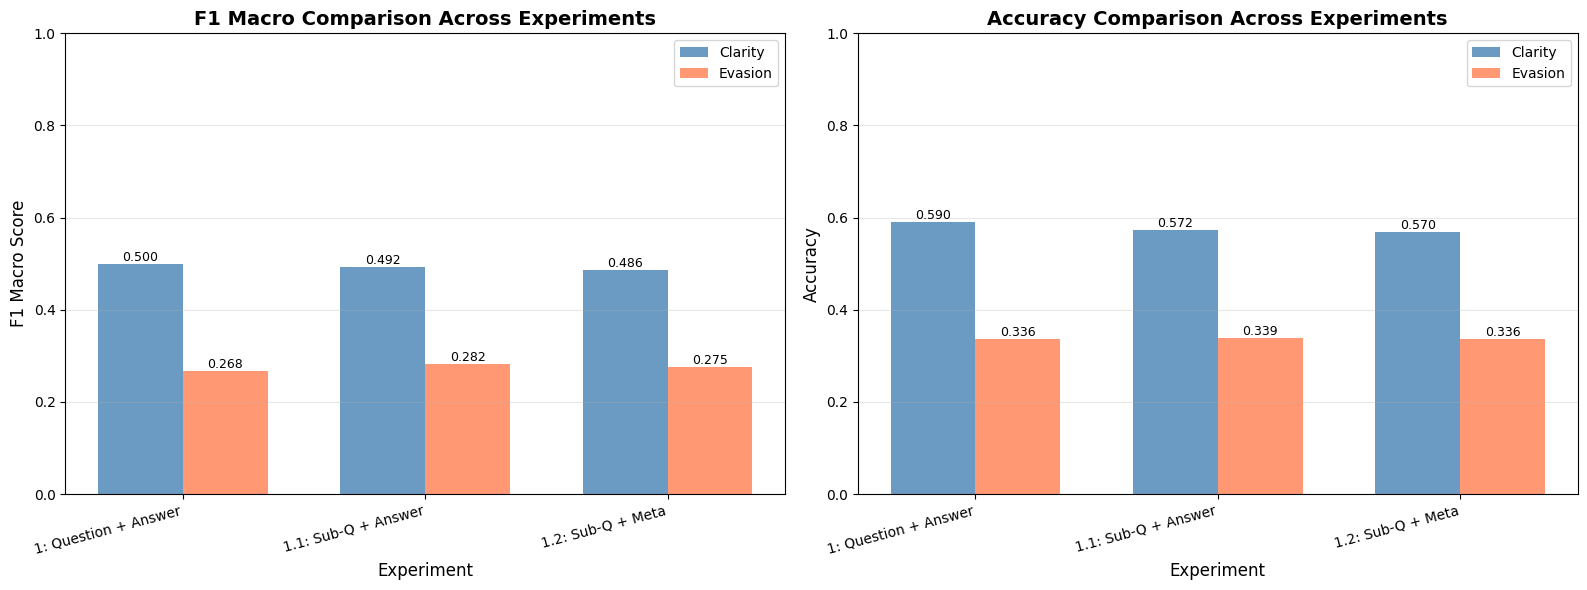


📈 IMPROVEMENT ANALYSIS:

Clarity Label:
  Baseline F1:    0.4999
  Best F1:        0.4999
  Improvement:    +0.0000 (+0.0%)

Evasion Label:
  Baseline F1:    0.2675
  Best F1:        0.2823
  Improvement:    +0.0148 (+5.5%)

💡 KEY INSIGHTS:
⚠ Different experiments perform best:
  - Clarity: Exp 1: Question + Answer
  - Evasion: Exp 1.1: Sub-Q + Answer

✓ Using sub-questions (Exp 1.1) improved focus on relevant context

✓ Results saved to: results/phase2_experiment1_comparison.csv


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# EXPERIMENT 1 SUMMARY: Compare All Sub-Experiments
# ============================================================================

print("\n" + "="*80)
print("EXPERIMENT 1 SUMMARY: Comparing All Sub-Experiments")
print("="*80)

# Collect metrics from all experiments
experiment_results = []

# Experiment 1: Contextual Sub-Q
experiment_results.append({
    'Experiment': 'Exp 1: Question + Answer',
    'F1 Macro (Clarity)': results['clarity']['global_metrics']['f1_macro'],
    'Accuracy (Clarity)': results['clarity']['global_metrics']['accuracy'],
    'F1 Macro (Evasion)': results['evasion']['global_metrics']['f1_macro'],
    'Accuracy (Evasion)': results['evasion']['global_metrics']['accuracy'],
})

# Experiment 1.1: Sub-Question Context
experiment_results.append({
    'Experiment': 'Exp 1.1: Sub-Q + Answer',
    'F1 Macro (Clarity)': results_ex1_1['clarity']['global_metrics']['f1_macro'],
    'Accuracy (Clarity)': results_ex1_1['clarity']['global_metrics']['accuracy'],
    'F1 Macro (Evasion)': results_ex1_1['evasion']['global_metrics']['f1_macro'],
    'Accuracy (Evasion)': results_ex1_1['evasion']['global_metrics']['accuracy'],
})

# Experiment 1.2: Context + Meta-features
experiment_results.append({
    'Experiment': 'Exp 1.2: Sub-Q + Meta',
    'F1 Macro (Clarity)': results_ex1_2['clarity']['global_metrics']['f1_macro'],
    'Accuracy (Clarity)': results_ex1_2['clarity']['global_metrics']['accuracy'],
    'F1 Macro (Evasion)': results_ex1_2['evasion']['global_metrics']['f1_macro'],
    'Accuracy (Evasion)': results_ex1_2['evasion']['global_metrics']['accuracy'],
})

# Create comparison DataFrame
comparison_df = pd.DataFrame(experiment_results)

# Display results table
print("\n📊 RESULTS COMPARISON:")
print(comparison_df.to_string(index=False))

# Find best performers
best_clarity_f1_idx = comparison_df['F1 Macro (Clarity)'].idxmax()
best_evasion_f1_idx = comparison_df['F1 Macro (Evasion)'].idxmax()

print("\n" + "="*80)
print("🏆 BEST PERFORMERS:")
print("="*80)
print(f"Best for Clarity:  {comparison_df.iloc[best_clarity_f1_idx]['Experiment']}")
print(f"  F1 Macro: {comparison_df.iloc[best_clarity_f1_idx]['F1 Macro (Clarity)']:.4f}")
print(f"  Accuracy: {comparison_df.iloc[best_clarity_f1_idx]['Accuracy (Clarity)']:.4f}")

print(f"\nBest for Evasion:  {comparison_df.iloc[best_evasion_f1_idx]['Experiment']}")
print(f"  F1 Macro: {comparison_df.iloc[best_evasion_f1_idx]['F1 Macro (Evasion)']:.4f}")
print(f"  Accuracy: {comparison_df.iloc[best_evasion_f1_idx]['Accuracy (Evasion)']:.4f}")

# ============================================================================
# VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: F1 Macro Comparison
exp_names = comparison_df['Experiment'].str.replace('Exp ', '').tolist()
x = np.arange(len(exp_names))
width = 0.35

ax1 = axes[0]
bars1 = ax1.bar(x - width/2, comparison_df['F1 Macro (Clarity)'], width, 
                label='Clarity', alpha=0.8, color='steelblue')
bars2 = ax1.bar(x + width/2, comparison_df['F1 Macro (Evasion)'], width, 
                label='Evasion', alpha=0.8, color='coral')

ax1.set_xlabel('Experiment', fontsize=12)
ax1.set_ylabel('F1 Macro Score', fontsize=12)
ax1.set_title('F1 Macro Comparison Across Experiments', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(exp_names, rotation=15, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 1.0)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

# Plot 2: Accuracy Comparison
ax2 = axes[1]
bars3 = ax2.bar(x - width/2, comparison_df['Accuracy (Clarity)'], width, 
                label='Clarity', alpha=0.8, color='steelblue')
bars4 = ax2.bar(x + width/2, comparison_df['Accuracy (Evasion)'], width, 
                label='Evasion', alpha=0.8, color='coral')

ax2.set_xlabel('Experiment', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Accuracy Comparison Across Experiments', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(exp_names, rotation=15, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 1.0)

# Add value labels on bars
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('figures/phase2_experiment1_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# IMPROVEMENT ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("📈 IMPROVEMENT ANALYSIS:")
print("="*80)

# Calculate improvements from baseline (Exp 1) to best experiment
baseline_clarity_f1 = comparison_df.iloc[0]['F1 Macro (Clarity)']
baseline_evasion_f1 = comparison_df.iloc[0]['F1 Macro (Evasion)']

best_clarity_f1 = comparison_df.iloc[best_clarity_f1_idx]['F1 Macro (Clarity)']
best_evasion_f1 = comparison_df.iloc[best_evasion_f1_idx]['F1 Macro (Evasion)']

clarity_improvement = best_clarity_f1 - baseline_clarity_f1
evasion_improvement = best_evasion_f1 - baseline_evasion_f1

clarity_improvement_pct = (clarity_improvement / baseline_clarity_f1) * 100
evasion_improvement_pct = (evasion_improvement / baseline_evasion_f1) * 100

print(f"\nClarity Label:")
print(f"  Baseline F1:    {baseline_clarity_f1:.4f}")
print(f"  Best F1:        {best_clarity_f1:.4f}")
print(f"  Improvement:    {clarity_improvement:+.4f} ({clarity_improvement_pct:+.1f}%)")

print(f"\nEvasion Label:")
print(f"  Baseline F1:    {baseline_evasion_f1:.4f}")
print(f"  Best F1:        {best_evasion_f1:.4f}")
print(f"  Improvement:    {evasion_improvement:+.4f} ({evasion_improvement_pct:+.1f}%)")

# ============================================================================
# KEY INSIGHTS
# ============================================================================

print("\n" + "="*80)
print("💡 KEY INSIGHTS:")
print("="*80)

if best_clarity_f1_idx == best_evasion_f1_idx:
    print(f"✓ {comparison_df.iloc[best_clarity_f1_idx]['Experiment']} performs best for BOTH tasks")
else:
    print(f"⚠ Different experiments perform best:")
    print(f"  - Clarity: {comparison_df.iloc[best_clarity_f1_idx]['Experiment']}")
    print(f"  - Evasion: {comparison_df.iloc[best_evasion_f1_idx]['Experiment']}")

if best_clarity_f1_idx == 2 or best_evasion_f1_idx == 2:
    print("\n✓ Adding meta-features (Exp 1.2) helped capture structural evasion patterns")
    
if best_clarity_f1_idx == 1 or best_evasion_f1_idx == 1:
    print("\n✓ Using sub-questions (Exp 1.1) improved focus on relevant context")

# Save comparison data
comparison_df.to_csv('results/phase2_experiment1_comparison.csv', index=False)
print("\n✓ Results saved to: results/phase2_experiment1_comparison.csv")
print("="*80)

## Experiment 2: N-gram Range Exploration
In political discourse, meaning is often tied to sequences of words (e.g., "I cannot recall" vs. "recall"). 
Here, we compare three configurations to find the optimal balance between granularity and context:
1. **Unigrams (1, 1):** Focuses on individual keywords.
2. **Bigrams (1, 2):** Captures short phrases and modifiers.
3. **Trigrams (1, 3):** Captures complex discourse markers and rhetorical patterns.

Testing N-gram range: (1, 1)...


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Testing N-gram range: (1, 2)...


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Testing N-gram range: (1, 3)...


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


    Range  Macro F1
0  (1, 1)  0.276084
1  (1, 2)  0.282324
2  (1, 3)  0.279954


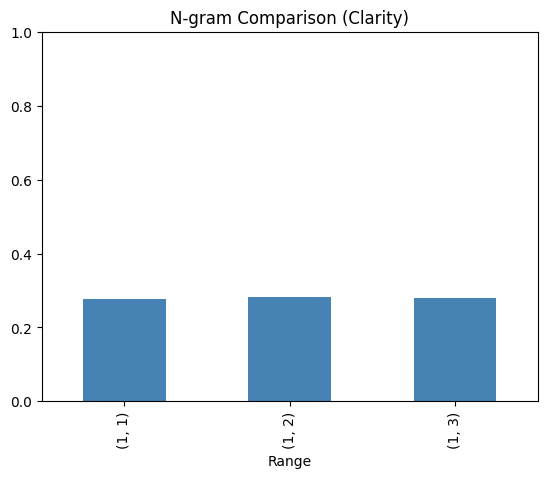

In [13]:
ngram_results = []
ngram_ranges = [(1, 1), (1, 2), (1, 3)]

for rng in ngram_ranges:
    print(f"Testing N-gram range: {rng}...")
    
    vec = CountVectorizer(stop_words='english', ngram_range=rng, max_features=None)
    X_train_vec = vec.fit_transform(train_df['sub_q_context'])
    X_val_vec = vec.transform(val_df['sub_q_context'])
    
    clf = LogisticRegression(max_iter=1000, multi_class="multinomial", random_state=SEED)
    clf.fit(X_train_vec, y_train_evasion)
    
    from sklearn.metrics import f1_score
    score = f1_score(y_val_evasion, clf.predict(X_val_vec), average='macro')
    
    ngram_results.append({'Range': str(rng), 'Macro F1': score})

ngram_comparison_df = pd.DataFrame(ngram_results)
print(ngram_comparison_df)

# Plotting
ngram_comparison_df.plot(x='Range', y='Macro F1', kind='bar', color='steelblue', legend=False)
plt.title('N-gram Comparison (Clarity)')
plt.ylim(0, 1.0)
plt.show()

## Experiment 3: Max Features Exploration
Political question evasion involves specific rhetorical strategies and discourse markers.
Here, we test different max_features values to determine the optimal vocabulary size for capturing evasive language patterns without introducing noise:
- **500:** Minimal vocabulary, core evasion indicators only.
- **1000:** Moderate vocabulary, common political rhetoric.
- **2000:** Expanded vocabulary, nuanced discourse patterns.
- **3000:** Comprehensive vocabulary, detailed rhetorical strategies.
- **5000:** Extensive vocabulary, full lexical diversity.

Testing max_features: 500...


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Testing max_features: 1000...


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Testing max_features: 2000...


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Testing max_features: 3000...


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Testing max_features: 5000...


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Testing max_features: None...


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


   Max Features  Macro F1
0         500.0  0.250164
1        1000.0  0.264484
2        2000.0  0.256694
3        3000.0  0.269753
4        5000.0  0.271435
5           NaN  0.282324


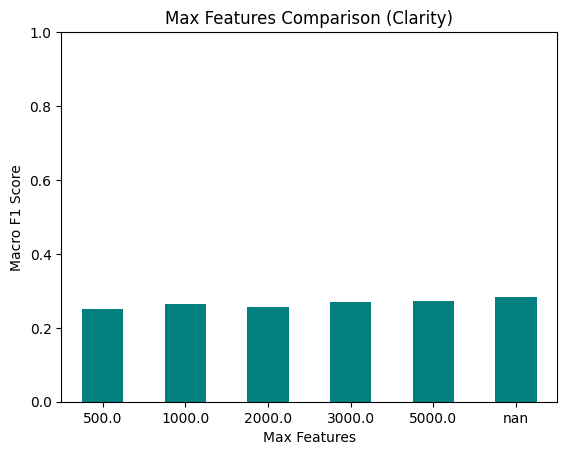

In [14]:
max_features_results = []
max_features_values = [500, 1000, 2000, 3000, 5000, None]

for max_feat in max_features_values:
    print(f"Testing max_features: {max_feat}...")
    
    vec = CountVectorizer(stop_words='english', ngram_range=(1, 2), max_features=max_feat)
    X_train_vec = vec.fit_transform(train_df['sub_q_context'])
    X_val_vec = vec.transform(val_df['sub_q_context'])
    
    clf = LogisticRegression(max_iter=1000, multi_class="multinomial", random_state=SEED)
    clf.fit(X_train_vec, y_train_evasion)
    
    from sklearn.metrics import f1_score
    score = f1_score(y_val_evasion, clf.predict(X_val_vec), average='macro')
    
    max_features_results.append({'Max Features': max_feat, 'Macro F1': score})

max_features_comparison_df = pd.DataFrame(max_features_results)
print(max_features_comparison_df)

# Plotting
max_features_comparison_df.plot(x='Max Features', y='Macro F1', kind='bar', color='teal', legend=False)
plt.title('Max Features Comparison (Clarity)')
plt.xlabel('Max Features')
plt.ylabel('Macro F1 Score')
plt.ylim(0, 1.0)
plt.xticks(rotation=0)
plt.show()